# Generate Training Data

In order to train the discriminative models, we need training data. To this end, we create synthetic training data via a simple simulation of kicks on goal. The algorithm works as follows:

- Sample a position (i.e. $x \in [0, 1]$ and $y \in [0, 2]$)
- Sample from one of the possible ranges `{wide-left`, `block-left`, `block-center`, `block-right`, `wide-right}`
- Sample from one the possible powers `{weak`, `strong}`
- Kick!
- Record each sample

### 1D Deterministic Data Generator

In [4]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['pos', 'vel', 'label'])
World = namedtuple('World', ['goal', 'end'])

def data_generator(world, num_starts=3, num_ends=5, time_steps=10, decay=.8):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    world : World
    The dimensions of the world
    
    num_starts : int
    The number of starting points you want
    
    num_ends : int
    The number of ending points you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """
    goal, end = world
    
    # Starting and ending points
    starts, ends = np.linspace(0, 1), np.linspace(1, 3, num_ends)
    
    for start, end in itertools.product(starts, ends):
        label = 1 if end >= 2 else 0
        
        # Starting velocities to reach the goal
        c = (1-decay) / (1-decay**(time_steps-1))
        dstart = c * (end-start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        velocities = decays * dstart

        # Distance traveled at each time step
        deltas = np.cumsum(velocities)

        # Compute the actual points given distances
        positions = start + deltas
        positions = np.append([start], positions[:-1])
        
        # Yield the points one by one
        for position, velocity in zip(positions, velocities):
            yield State(position, velocity, label)


data_points = data_generator(World(goal=2, end=5), num_starts=5, num_ends=5)
data_points = list(data_points)

pd.DataFrame(data_points, columns=State._fields).groupby('label').size()

label
0    1000
1    1500
dtype: int64

### Filter Away Invisible Points

In [5]:
data_points = [data_point for data_point in data_points if data_point.pos <= 2]

data_points_1d = pd.DataFrame(data_points, columns=State._fields)
 
data_points_1d.groupby('label').size()

label
0    1000
1     942
dtype: int64

### Restore Class Balance

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


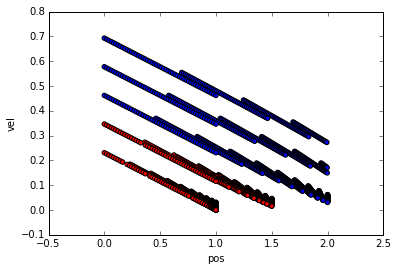

In [10]:
groups = data_points_1d.groupby('label')
max_size = groups.size().min()

def filter_down(group):
    """Filters down a pandas groupby object to a specified number"""
    
    size = len(group)
    mask = np.full(size, False, bool)
    lucky_indices = np.random.choice(size, max_size, replace=False)
    mask[lucky_indices] = True
    
    return group[mask]

balanced_data_1d = groups.apply(filter_down)

# Plot it
labels = balanced_data_1d['label']
colormap = np.array(['r', 'b'])
balanced_data_1d.plot(kind='scatter', x='pos', y='vel', c=colormap[labels])

In [14]:
data_1d = balanced_data_1d

%store data_1d

Stored 'data_1d' (DataFrame)
